# Task 4 - Causal inference: effect of adjuvant hormonal therapy

**Clinical estimand:** ATT (effect among patients who received hormonal therapy).  
Reason: eligibility and prescribing are strongly driven by hormone receptor status, so overlap for an ATE is limited.

**Primary outcomes (time-to-event):**
- Overall survival (OS): `dtime`, `death`
- Recurrence-free survival (RFS): derived from `rtime`, `recur`, `dtime`, `death`


In [36]:
%pip -q install tableone lifelines statsmodels scikit-learn patsy


Note: you may need to restart the kernel to use updated packages.


In [37]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm

# Optional (used for survival + weighted Cox/KM)
from lifelines import CoxPHFitter, KaplanMeierFitter

from tableone import TableOne


In [38]:
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

# ---- User parameters ----
DATA_PATH = "../rotterdam.csv"
TAU_YEARS = 7
TAU_DAYS  = int(round(TAU_YEARS * 365.25))

TREAT_COL = "hormon"


## 0) Load and quick checks


In [39]:
df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head()


Shape: (2982, 16)


,pid,year,age,hospital_id,meno,size,grade,nodes,pgr,er,hormon,chemo,rtime,recur,dtime,death
0,1,1992,74,16,1,<=20,3,0,35,291,0,0,1799,0,1799,0
1,2,1984,79,4,1,20-50,3,0,36,611,0,0,2828,0,2828,0
2,3,1983,44,2,0,<=20,2,0,138,0,0,0,6012,1,6012,0
3,4,1985,70,5,1,20-50,3,0,0,12,0,0,2624,0,2624,0
4,5,1983,75,17,1,<=20,3,0,260,409,0,0,4915,0,4915,0


In [40]:
expected = ["pid","age","year","hospital_id","meno","nodes","size","grade",
            "er","pgr","hormon","chemo","rtime","recur","dtime","death"]
missing = [c for c in expected if c not in df_raw.columns]
print("Missing expected columns:", missing)


Missing expected columns: []


## 1) Cleaning and feature setup


In [41]:
df = df_raw.copy()

# Ensure binary coding is consistent
for col in ["meno","hormon","chemo","recur","death"]:
    df[col] = df[col].astype(int)

# Exam spec uses ER/PGR positivity cut at 10 fmol/mg (keep continuous too for sensitivity)
df["er_pos"]  = (df["er"]  >= 10).astype(int)
df["pgr_pos"] = (df["pgr"] >= 10).astype(int)
df["hr_pos"]  = ((df["er_pos"]==1) | (df["pgr_pos"]==1)).astype(int)

# Ordinals: grade (1<2<3), size is typically categorical in this dataset
df["grade"] = pd.to_numeric(df["grade"], errors="coerce")
df["size"]  = df["size"].astype("category")

# Non-linear-ish transforms commonly useful (used in sensitivity later)
df["log_nodes"] = np.log1p(df["nodes"].clip(lower=0))
df["inv_sqrt_nodes"] = 1.0 / np.sqrt(df["nodes"].clip(lower=0.5))  # avoids /0

# Administrative censoring at TAU for both endpoints
df["dtime_tau"]  = np.minimum(df["dtime"], TAU_DAYS)
df["death_tau"]  = ((df["death"]==1) & (df["dtime"]<=TAU_DAYS)).astype(int)

df["rtime_tau"]  = np.minimum(df["rtime"], TAU_DAYS)
df["recur_tau"]  = ((df["recur"]==1) & (df["rtime"]<=TAU_DAYS)).astype(int)

# RFS (Royston-style: event is recurrence OR death, time is recurrence time if recur else death time)
df["rfstime_tau_royston"] = np.where(df["recur_tau"]==1, df["rtime_tau"], df["dtime_tau"])
df["rfs_tau_royston"]     = ((df["recur_tau"]==1) | (df["death_tau"]==1)).astype(int)

# Conservative alternative for the known "death after recurrence censor" pattern:
# if no recorded recurrence by rtime, and rtime < dtime, we censor at rtime (do NOT count death as RFS event)
df["rfstime_tau_cons"] = df["rtime_tau"]
df["rfs_tau_cons"]     = df["recur_tau"].copy()

mask_death_after_recur_censor = (df["recur_tau"]==0) & (df["death_tau"]==1) & (df["rtime_tau"] < df["dtime_tau"])
df.loc[~mask_death_after_recur_censor, "rfstime_tau_cons"] = np.where(
    df.loc[~mask_death_after_recur_censor, "recur_tau"]==1,
    df.loc[~mask_death_after_recur_censor, "rtime_tau"],
    df.loc[~mask_death_after_recur_censor, "dtime_tau"]
)
df.loc[~mask_death_after_recur_censor, "rfs_tau_cons"] = np.where(
    df.loc[~mask_death_after_recur_censor, "recur_tau"]==1,
    1,
    df.loc[~mask_death_after_recur_censor, "death_tau"]
).astype(int)

print("Potential RFS-definition-quirk rows (death after recur censor):", mask_death_after_recur_censor.sum())


Potential RFS-definition-quirk rows (death after recur censor): 343


In [42]:
# Drop rows with missing key fields (keep it explicit)
key_cols = ["age","nodes","size","grade","er","pgr","meno","year","hospital_id","chemo",TREAT_COL,
            "dtime_tau","death_tau","rfstime_tau_royston","rfs_tau_royston"]
df = df.dropna(subset=key_cols).copy()
print("After dropping missing key cols:", df.shape)

# Optional restriction to "eligible" cohort (HR+). Keep both for sensitivity.
df_eligible = df[df["hr_pos"]==1].copy()
print("Eligible (HR+) cohort:", df_eligible.shape)


After dropping missing key cols: (2982, 29)
Eligible (HR+) cohort: (2420, 29)


## 2) Descriptives


In [43]:
print("Baseline table (full cohort)")
print("Treatment prevalence:", df[TREAT_COL].mean().round(3))
TableOne(df, columns=["age","meno","nodes","log_nodes","size","grade","er","pgr","er_pos","pgr_pos","chemo"], groupby=TREAT_COL, pval=True, smd=True)


Baseline table (full cohort)
Treatment prevalence: 0.114


Grouped by hormon                                                               
                                     Missing        Overall              0              1 SMD (0,1) P-Value
n                                                      2982           2643            339                  
age, mean (SD)                             0    55.1 (13.0)    54.1 (13.0)     62.5 (9.9)     0.731  <0.001
meno, n (%)          0                          1312 (44.0)    1271 (48.1)      41 (12.1)     0.853  <0.001
                     1                          1670 (56.0)    1372 (51.9)     298 (87.9)                  
nodes, mean (SD)                           0      2.7 (4.4)      2.3 (4.2)      5.7 (4.6)     0.772  <0.001
log_nodes, mean (SD)                       0      0.8 (0.9)      0.7 (0.9)      1.7 (0.7)     1.201  <0.001
size, n (%)          20-50                      1291 (43.3)    1119 (42.3)     172 (50.7)     0.409  <0.001
                     <=20                       1387 (46.5)    1283 (48.5)     104 (30.7)                  
                     >50                         304 (10.2)      241 (9.1)      63 (18.6)                  
grade, n (%)         2                           794 (26.6)     735 (27.8)      59 (17.4)     0.251  <0.001
                     3                          2188 (73.4)    1908 (72.2)     280 (82.6)                  
er, mean (SD)                              0  166.6 (272.5)  164.8 (272.6)  180.6 (271.7)     0.058   0.314
pgr, mean (SD)                             0  161.8 (291.3)  168.7 (300.3)  108.2 (200.3)    -0.237  <0.001
er_pos, n (%)        0                           704 (23.6)     630 (23.8)      74 (21.8)     0.048   0.452
                     1                          2278 (76.4)    2013 (76.2)     265 (78.2)                  
pgr_pos, n (%)       0                           951 (31.9)     814 (30.8)     137 (40.4)     0.202  <0.001
                     1                          2031 (68.1)    1829 (69.2)     202 (59.6)                  
chemo, n (%)         0                          2402 (80.5)    2091 (79.1)     311 (91.7)     0.364  <0.001
                     1                           580 (19.5)     552 (20.9)       28 (8.3)

In [44]:

print("Baseline table (HR+ eligible cohort)")
print("Treatment prevalence:", df_eligible[TREAT_COL].mean().round(3))
TableOne(df, columns=["age","meno","nodes","log_nodes","size","grade","er","pgr","er_pos","pgr_pos","chemo"], groupby=TREAT_COL, pval=True, smd=True)


Baseline table (HR+ eligible cohort)
Treatment prevalence: 0.113


Grouped by hormon                                                               
                                     Missing        Overall              0              1 SMD (0,1) P-Value
n                                                      2982           2643            339                  
age, mean (SD)                             0    55.1 (13.0)    54.1 (13.0)     62.5 (9.9)     0.731  <0.001
meno, n (%)          0                          1312 (44.0)    1271 (48.1)      41 (12.1)     0.853  <0.001
                     1                          1670 (56.0)    1372 (51.9)     298 (87.9)                  
nodes, mean (SD)                           0      2.7 (4.4)      2.3 (4.2)      5.7 (4.6)     0.772  <0.001
log_nodes, mean (SD)                       0      0.8 (0.9)      0.7 (0.9)      1.7 (0.7)     1.201  <0.001
size, n (%)          20-50                      1291 (43.3)    1119 (42.3)     172 (50.7)     0.409  <0.001
                     <=20                       1387 (46.5)    1283 (48.5)     104 (30.7)                  
                     >50                         304 (10.2)      241 (9.1)      63 (18.6)                  
grade, n (%)         2                           794 (26.6)     735 (27.8)      59 (17.4)     0.251  <0.001
                     3                          2188 (73.4)    1908 (72.2)     280 (82.6)                  
er, mean (SD)                              0  166.6 (272.5)  164.8 (272.6)  180.6 (271.7)     0.058   0.314
pgr, mean (SD)                             0  161.8 (291.3)  168.7 (300.3)  108.2 (200.3)    -0.237  <0.001
er_pos, n (%)        0                           704 (23.6)     630 (23.8)      74 (21.8)     0.048   0.452
                     1                          2278 (76.4)    2013 (76.2)     265 (78.2)                  
pgr_pos, n (%)       0                           951 (31.9)     814 (30.8)     137 (40.4)     0.202  <0.001
                     1                          2031 (68.1)    1829 (69.2)     202 (59.6)                  
chemo, n (%)         0                          2402 (80.5)    2091 (79.1)     311 (91.7)     0.364  <0.001
                     1                           580 (19.5)     552 (20.9)       28 (8.3)

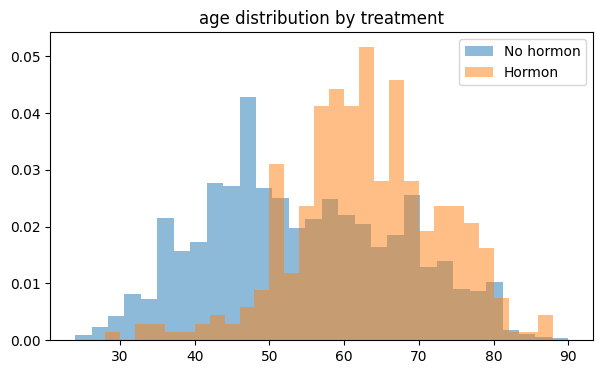

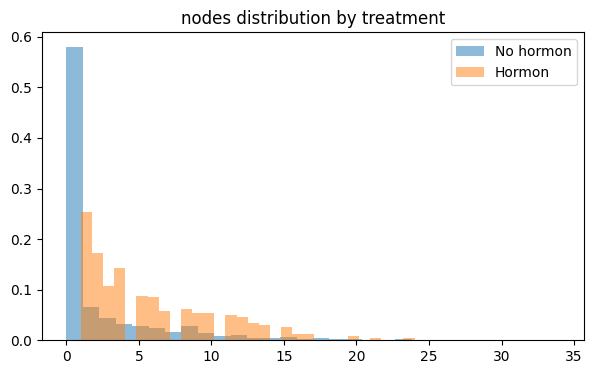

In [45]:
def plot_hist_by_treat(df_in, col, bins=30):
    plt.figure(figsize=(7,4))
    for t,lab in [(0,"No hormon"), (1,"Hormon")]:
        x = df_in.loc[df_in[TREAT_COL]==t, col].dropna()
        plt.hist(x, bins=bins, alpha=0.5, density=True, label=lab)
    plt.title(f"{col} distribution by treatment")
    plt.legend()
    plt.show()

plot_hist_by_treat(df, "age", bins=30)
plot_hist_by_treat(df, "nodes", bins=30)


## 3) Propensity score model (ATT)

Logistic regression PS with a simple, interpretable encoding:
- continuous: age, log_nodes, er, pgr
- binary: meno, chemo, ER/PGR status
- categorical: size, grade


In [46]:
D = df_eligible.copy()  # primary: HR+ cohort

# Pre-treatment covariates only
cov_cont = ["age","log_nodes","er","pgr"]
cov_bin  = ["meno","chemo","er_pos","pgr_pos"]
cov_cat  = ["size","grade"]

X = D[cov_cont + cov_bin + cov_cat]
y = D[TREAT_COL].astype(int)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cov_cat),
        ("num", "passthrough", cov_cont + cov_bin)
    ],
    remainder="drop"
)

ps_model = Pipeline(steps=[
    ("prep", preprocess),
    ("logit", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

ps_model.fit(X, y)
ps = ps_model.predict_proba(X)[:,1]
D["ps"] = ps
D["logit_ps"] = np.log(ps / (1-ps))

print("PS model AUC (not the goal, but a sanity check):", round(roc_auc_score(y, ps), 3))
print("PS range:", (round(ps.min(), 4), round(ps.max(), 4)))


PS model AUC (not the goal, but a sanity check): 0.834
PS range: (np.float64(0.002), np.float64(0.722))


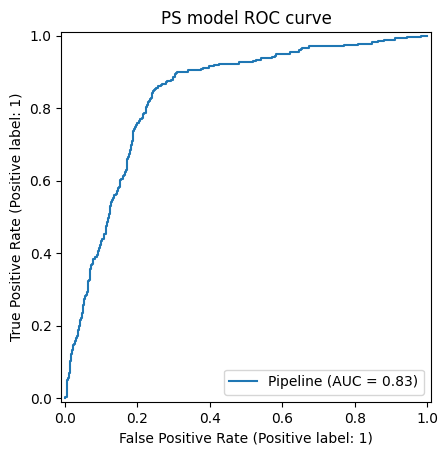

In [68]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(ps_model, X, y)
plt.title("PS model ROC curve")
plt.show()

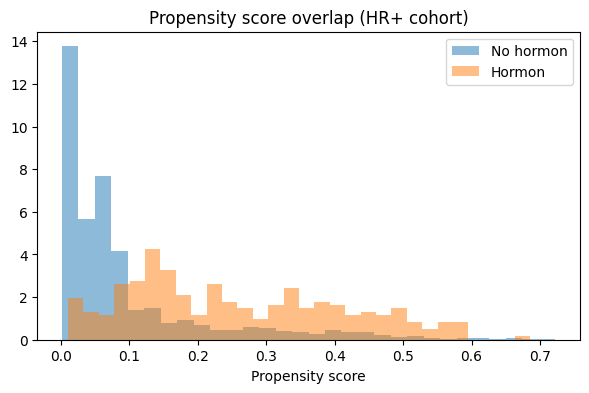

Common support bounds (treated 1%-99% quantiles): 0.014569642804970006 0.5853886609702312
Rows kept: (2166, 31)  (dropped: 254 )


In [47]:
plt.figure(figsize=(7,4))
for t,lab in [(0,"No hormon"), (1,"Hormon")]:
    x = D.loc[D[TREAT_COL]==t, "ps"]
    plt.hist(x, bins=30, alpha=0.5, density=True, label=lab)
plt.title("Propensity score overlap (HR+ cohort)")
plt.xlabel("Propensity score")
plt.legend()
plt.show()

ps_treated = D.loc[D[TREAT_COL]==1, "ps"]
lo, hi = ps_treated.quantile(0.01), ps_treated.quantile(0.99)

D_cs = D[(D["ps"]>=lo) & (D["ps"]<=hi)].copy()
print("Common support bounds (treated 1%-99% quantiles):", float(lo), float(hi))
print("Rows kept:", D_cs.shape, " (dropped:", D.shape[0]-D_cs.shape[0], ")")


## 4) Balance diagnostics (SMD + Love plot)


In [48]:
def smd_cont(x_t, x_c):
    # standardized mean difference for continuous
    mt, mc = np.mean(x_t), np.mean(x_c)
    vt, vc = np.var(x_t, ddof=1), np.var(x_c, ddof=1)
    return (mt - mc) / np.sqrt((vt + vc)/2)

def smd_bin(x_t, x_c):
    # same formula works for binary
    return smd_cont(x_t, x_c)

def smd_onehot(df_in, treat_col, cols_cont, cols_bin, cols_cat):
    # One-hot for categorical and compute SMD per resulting column
    dfw = df_in.copy()
    dfw = pd.get_dummies(dfw, columns=cols_cat, drop_first=True, dummy_na=False)

    treat = dfw[treat_col].values.astype(int)
    tmask = (treat==1)
    cmask = (treat==0)

    smds = {}
    for c in cols_cont + cols_bin:
        smds[c] = smd_cont(dfw.loc[tmask, c].values, dfw.loc[cmask, c].values)

    cat_cols = [c for c in dfw.columns if any(c.startswith(k+"_") for k in cols_cat)]
    for c in cat_cols:
        smds[c] = smd_bin(dfw.loc[tmask, c].values, dfw.loc[cmask, c].values)

    out = (pd.Series(smds).sort_values(key=lambda s: np.abs(s), ascending=False)
             .to_frame("SMD")
             .assign(absSMD=lambda d: np.abs(d["SMD"])))
    return out

def love_plot(smd_df, title="Love plot", thresh=0.1, top=40):
    d = smd_df.sort_values("absSMD", ascending=True).tail(top)
    plt.figure(figsize=(7, max(4, top*0.15)))
    plt.scatter(d["SMD"], range(d.shape[0]))
    plt.axvline(thresh, linestyle="--")
    plt.axvline(-thresh, linestyle="--")
    plt.yticks(range(d.shape[0]), d.index)
    plt.title(title)
    plt.xlabel("Standardized mean difference")
    plt.tight_layout()
    plt.show()


In [49]:
# Baseline imbalance (before adjustment) on common-support cohort
cov_cont_smd = ["age","log_nodes","er","pgr"]
cov_bin_smd  = ["meno","chemo","er_pos","pgr_pos"]
cov_cat_smd  = ["size","grade"]

smd_pre = smd_onehot(D_cs, TREAT_COL, cov_cont_smd, cov_bin_smd, cov_cat_smd)
smd_pre.head(12)


,SMD,absSMD
log_nodes,1.080668,1.080668
meno,0.675066,0.675066
age,0.553773,0.553773
chemo,-0.343841,0.343841
size_<=20,-0.338520,0.338520
size_>50,0.252897,0.252897
pgr_pos,-0.218965,0.218965
pgr,-0.215192,0.215192
grade_3,0.175386,0.175386
er_pos,0.063634,0.063634


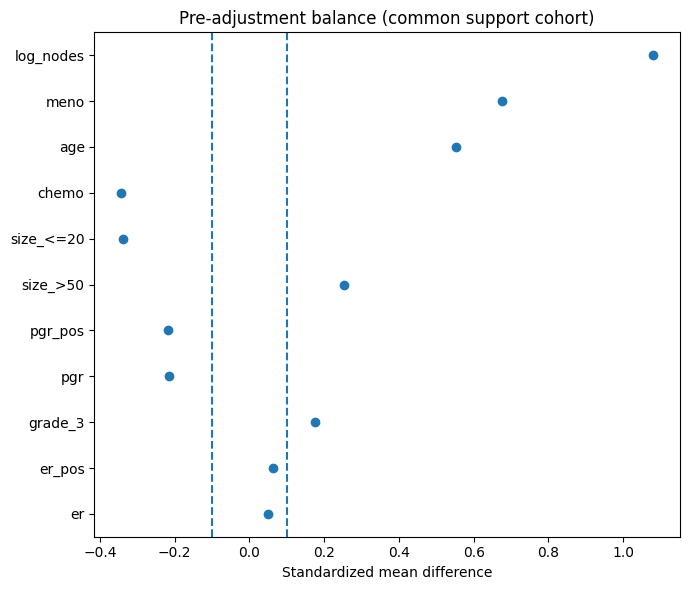

In [50]:
love_plot(smd_pre, title="Pre-adjustment balance (common support cohort)")


## 5) Method A - Propensity score matching (ATT)

Greedy 1:1 nearest-neighbor matching on logit(PS) with caliper = 0.2 * SD(logitPS).
- The first run uses replacement (controls may be reused).
- A no-replacement version is shown afterward for comparison.


In [51]:
from sklearn.neighbors import NearestNeighbors

def ps_match_1to1(df_in, treat_col="hormon", ps_col="logit_ps", caliper=None):
    df = df_in.copy()
    treated  = df[df[treat_col]==1].copy()
    control  = df[df[treat_col]==0].copy()

    if caliper is None:
        caliper = 0.2 * np.std(df[ps_col])

    # nearest neighbor on logit ps
    nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(control[[ps_col]].values)
    distances, indices = nbrs.kneighbors(treated[[ps_col]].values)

    treated["match_dist"] = distances[:,0]
    treated["match_idx"]  = indices[:,0]
    treated = treated[treated["match_dist"] <= caliper].copy()

    matched_control = control.iloc[treated["match_idx"].values].copy()
    matched_control.index = treated.index

    matched = pd.concat([treated, matched_control], axis=0, ignore_index=False)
    matched["pair_id"] = np.repeat(np.arange(treated.shape[0]), 2)

    matched = matched.reset_index(drop=True)
    return matched, caliper

matched, cal = ps_match_1to1(df_in=D_cs, treat_col=TREAT_COL, ps_col="logit_ps", caliper=None)
print("Matched rows:", matched.shape, "| caliper:", cal)
print("Matched treated:", (matched[TREAT_COL]==1).sum(), "Matched controls:", (matched[TREAT_COL]==0).sum())


Matched rows: (534, 34) | caliper: 0.23218080162230598
Matched treated: 267 Matched controls: 267


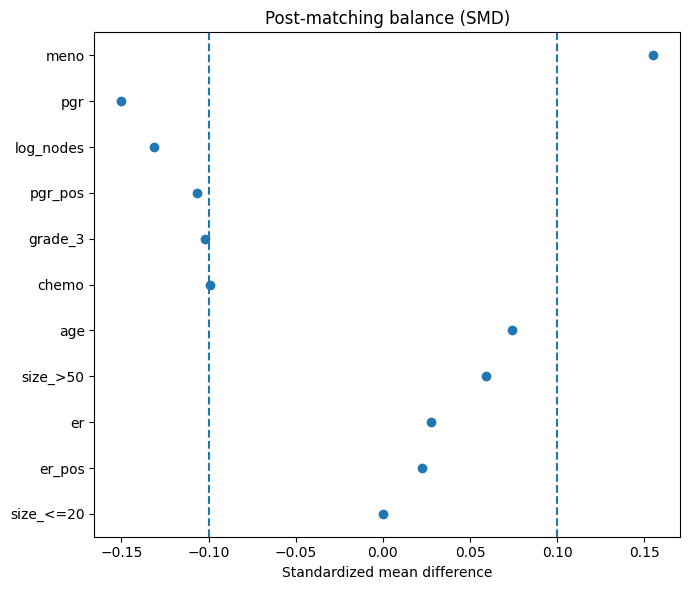

In [52]:
# Balance after matching
smd_post_match = smd_onehot(matched, TREAT_COL, cov_cont_smd, cov_bin_smd, cov_cat_smd)
love_plot(smd_post_match, title="Post-matching balance (SMD)")


No-replacement matched rows: (534, 36) | caliper: 0.23218080162230598
Matched treated: 267 Matched controls: 267


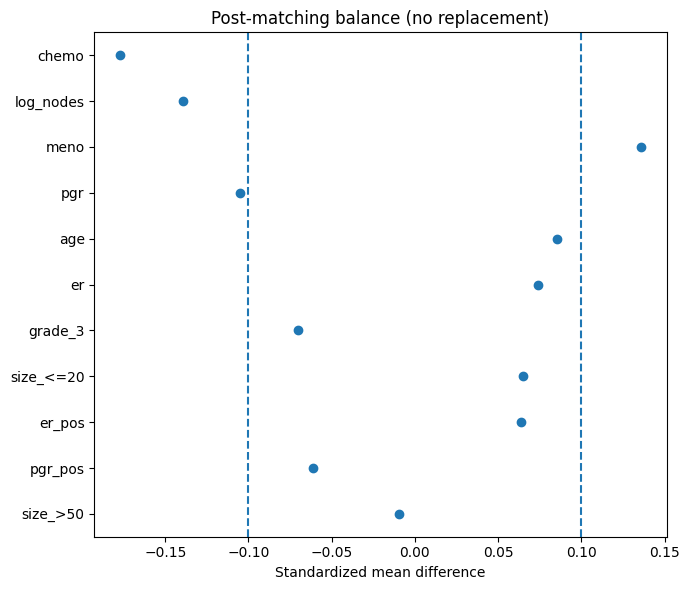

In [72]:
from bisect import bisect_left

def ps_match_1to1_no_replacement(df_in, treat_col="hormon", ps_col="logit_ps", caliper=None):
    df = df_in.copy()
    treated = df[df[treat_col]==1].copy()
    control = df[df[treat_col]==0].copy()

    if caliper is None:
        caliper = 0.2 * np.std(df[ps_col])

    control = control.sort_values(ps_col).copy()
    control_ps = control[ps_col].to_numpy()
    control_idx = control.index.to_list()

    matched_rows = []
    pair_id = 0
    for t_idx, t_row in treated.iterrows():
        pos = bisect_left(control_ps, t_row[ps_col])
        candidates = []
        if pos - 1 >= 0:
            candidates.append(pos - 1)
        if pos < len(control_ps):
            candidates.append(pos)

        if not candidates:
            continue

        best_pos = min(candidates, key=lambda p: abs(control_ps[p] - t_row[ps_col]))
        dist = abs(control_ps[best_pos] - t_row[ps_col])
        if dist > caliper:
            continue

        c_idx = control_idx[best_pos]
        c_row = control.loc[c_idx]

        t_out = t_row.copy()
        t_out["match_dist"] = dist
        t_out["match_idx"] = c_idx
        t_out["pair_id"] = pair_id

        c_out = c_row.copy()
        c_out["match_dist"] = dist
        c_out["match_idx"] = c_idx
        c_out["pair_id"] = pair_id

        matched_rows.append(t_out)
        matched_rows.append(c_out)
        pair_id += 1

        control_ps = np.delete(control_ps, best_pos)
        control_idx.pop(best_pos)

    matched = pd.DataFrame(matched_rows).reset_index(drop=True)
    return matched, caliper

matched_nr, cal_nr = ps_match_1to1_no_replacement(df_in=D_cs, treat_col=TREAT_COL, ps_col="logit_ps", caliper=None)
print("No-replacement matched rows:", matched_nr.shape, "| caliper:", cal_nr)
print("Matched treated:", (matched_nr[TREAT_COL]==1).sum(), "Matched controls:", (matched_nr[TREAT_COL]==0).sum())

if matched_nr.shape[0] > 0:
    smd_post_match_nr = smd_onehot(matched_nr, TREAT_COL, cov_cont_smd, cov_bin_smd, cov_cat_smd)
    love_plot(smd_post_match_nr, title="Post-matching balance (no replacement)")
else:
    print("No matches within caliper for the no-replacement run.")

Quick note: no-replacement matching usually yields fewer pairs. If it drops too many treated patients or worsens balance, the with-replacement set is the safer ATT choice for the primary analysis. The Cox models below use the with-replacement matched set (`matched`).

In [53]:
# Stratified Cox on matched pairs: OS
m_os = matched[[TREAT_COL,"dtime_tau","death_tau","pair_id"] + cov_cont_smd + cov_bin_smd].copy()
m_os = m_os.rename(columns={"dtime_tau":"T", "death_tau":"E"})

cph = CoxPHFitter()
cph.fit(m_os, duration_col="T", event_col="E", strata=["pair_id"])
cph.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hormon,14.981337,3.208575e+06,2851.446226,-5573.750569,5603.713244,0.000000,inf,0.0,0.005254,0.995808,0.006061
age,0.017485,1.017638e+00,0.014092,-0.010135,0.045104,0.989916,1.046137,0.0,1.240760,0.214694,2.219644
log_nodes,0.402551,1.495635e+00,0.160165,0.088634,0.716468,1.092681,2.047189,0.0,2.513357,0.011959,6.385782
er,-0.001032,9.989688e-01,0.000551,-0.002111,0.000048,0.997891,1.000048,0.0,-1.873620,0.060983,4.035453
pgr,0.000709,1.000709e+00,0.000536,-0.000341,0.001759,0.999659,1.001761,0.0,1.323873,0.185545,2.430158
meno,0.124358,1.132421e+00,0.413144,-0.685389,0.934104,0.503894,2.544932,0.0,0.301003,0.763412,0.389466
chemo,-0.203479,8.158876e-01,0.452185,-1.089746,0.682789,0.336302,1.979390,0.0,-0.449990,0.652718,0.615468
er_pos,0.471500,1.602397e+00,0.810762,-1.117563,2.060564,0.327076,7.850398,0.0,0.581552,0.560868,0.834266
pgr_pos,-0.281695,7.545035e-01,0.310195,-0.889666,0.326275,0.410793,1.385797,0.0,-0.908124,0.363813,1.458732


In [54]:
# Stratified Cox on matched pairs: RFS
m_rfs = matched[[TREAT_COL,"rfstime_tau_royston","rfs_tau_royston","pair_id"] + cov_cont_smd + cov_bin_smd].copy()
m_rfs = m_rfs.rename(columns={"rfstime_tau_royston":"T", "rfs_tau_royston":"E"})

cph_rfs = CoxPHFitter()
cph_rfs.fit(m_rfs, duration_col="T", event_col="E", strata=["pair_id"])
cph_rfs.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hormon,14.701473,2.425317e+06,2704.020473,-5285.081267,5.314484e+03,0.000000,inf,0.0,0.005437,9.956620e-01,0.006272
age,0.012033,1.012106e+00,0.013586,-0.014595,3.866090e-02,0.985511,1.039418,0.0,0.885697,3.757809e-01,1.412036
log_nodes,0.863485,2.371411e+00,0.175014,0.520464,1.206506e+00,1.682809,3.341787,0.0,4.933812,8.064012e-07,20.241999
er,-0.000962,9.990381e-01,0.000491,-0.001925,5.447119e-07,0.998077,1.000001,0.0,-1.958855,5.012974e-02,4.318189
pgr,0.001622,1.001623e+00,0.000568,0.000509,2.735170e-03,1.000509,1.002739,0.0,2.855564,4.296046e-03,7.862775
meno,0.459817,1.583783e+00,0.410354,-0.344463,1.264096e+00,0.708601,3.539892,0.0,1.120535,2.624857e-01,1.929690
chemo,-0.982234,3.744737e-01,0.459081,-1.882015,-8.245182e-02,0.152283,0.920856,0.0,-2.139566,3.238986e-02,4.948314
er_pos,-0.233785,7.915320e-01,0.694907,-1.595777,1.128207e+00,0.202751,3.090111,0.0,-0.336426,7.365493e-01,0.441146
pgr_pos,-0.286628,7.507907e-01,0.299184,-0.873018,2.997609e-01,0.417689,1.349536,0.0,-0.958035,3.380453e-01,1.564711


## 6) Method B - IPTW (ATT weights)

ATT weights:
- treated: 1
- controls: ps/(1-ps)


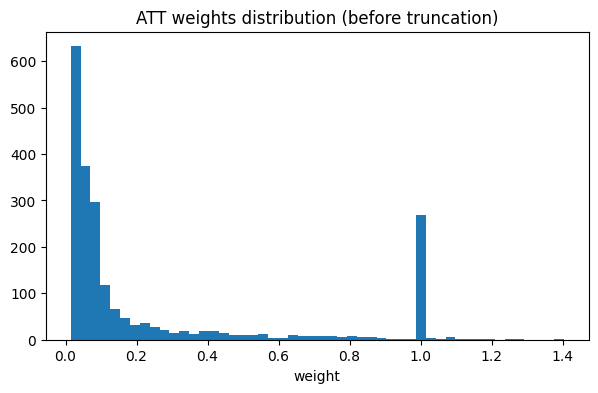

ATT weight truncation bounds: 0.015123011427010502 1.0


In [55]:
W = np.where(D_cs[TREAT_COL]==1, 1.0, D_cs["ps"]/(1.0 - D_cs["ps"]))
D_cs["w_att"] = W

plt.figure(figsize=(7,4))
plt.hist(D_cs["w_att"], bins=50)
plt.title("ATT weights distribution (before truncation)")
plt.xlabel("weight")
plt.show()

w_lo, w_hi = np.quantile(D_cs["w_att"], [0.01, 0.99])
D_cs["w_att_trunc"] = D_cs["w_att"].clip(w_lo, w_hi)
print("ATT weight truncation bounds:", float(w_lo), float(w_hi))


In [56]:
# Weighted Cox for OS (ATT)
w_os = D_cs[[TREAT_COL,"dtime_tau","death_tau","w_att_trunc"] + cov_cont_smd + cov_bin_smd].copy()
w_os = w_os.rename(columns={"dtime_tau":"T", "death_tau":"E", "w_att_trunc":"W"})

cph_w = CoxPHFitter()
cph_w.fit(w_os, duration_col="T", event_col="E", weights_col="W", robust=True)
cph_w.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hormon,-0.333771,0.716218,0.117851,-0.564755,-0.102788,0.568500,0.902318,0.0,-2.832150,4.623620e-03,7.756762
age,0.022919,1.023183,0.008122,0.007000,0.038837,1.007025,1.039601,0.0,2.821902,4.773975e-03,7.710593
log_nodes,0.707097,2.028096,0.062816,0.583981,0.830214,1.793162,2.293810,0.0,11.256675,2.147065e-29,95.233549
er,-0.000379,0.999621,0.000227,-0.000825,0.000066,0.999176,1.000066,0.0,-1.669504,9.501763e-02,3.395661
pgr,-0.000436,0.999564,0.000254,-0.000934,0.000062,0.999066,1.000062,0.0,-1.715041,8.633773e-02,3.533865
meno,-0.301697,0.739562,0.217009,-0.727027,0.123632,0.483344,1.131600,0.0,-1.390253,1.644521e-01,2.604261
chemo,-0.149160,0.861432,0.199414,-0.540003,0.241684,0.582747,1.273391,0.0,-0.747991,4.544654e-01,1.137758
er_pos,0.146521,1.157799,0.255955,-0.355141,0.648183,0.701074,1.912063,0.0,0.572448,5.670183e-01,0.818533
pgr_pos,-0.467832,0.626358,0.140949,-0.744088,-0.191577,0.475167,0.825656,0.0,-3.319152,9.029125e-04,10.113126


In [57]:
# Weighted Cox for RFS (ATT, Royston definition)
w_rfs = D_cs[[TREAT_COL,"rfstime_tau_royston","rfs_tau_royston","w_att_trunc"] + cov_cont_smd + cov_bin_smd].copy()
w_rfs = w_rfs.rename(columns={"rfstime_tau_royston":"T", "rfs_tau_royston":"E", "w_att_trunc":"W"})

cph_w_rfs = CoxPHFitter()
cph_w_rfs.fit(w_rfs, duration_col="T", event_col="E", weights_col="W", robust=True)
cph_w_rfs.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hormon,-0.338375,0.712928,0.103504,-0.541239,-0.135511,0.582027,0.873269,0.0,-3.269201,1.078518e-03,9.856734
age,0.010351,1.010405,0.006921,-0.003215,0.023917,0.996790,1.024205,0.0,1.495474,1.347908e-01,2.891206
log_nodes,0.730050,2.075184,0.061692,0.609136,0.850965,1.838841,2.341905,0.0,11.833751,2.612022e-32,104.916532
er,-0.000385,0.999615,0.000206,-0.000789,0.000019,0.999211,1.000019,0.0,-1.866360,6.199101e-02,4.011797
pgr,-0.000046,0.999954,0.000218,-0.000473,0.000381,0.999527,1.000381,0.0,-0.209840,8.337923e-01,0.262240
meno,-0.132477,0.875923,0.186819,-0.498635,0.233681,0.607359,1.263242,0.0,-0.709118,4.782510e-01,1.064160
chemo,-0.360433,0.697374,0.181970,-0.717087,-0.003779,0.488172,0.996228,0.0,-1.980733,4.762119e-02,4.392253
er_pos,0.332966,1.395100,0.258236,-0.173168,0.839101,0.840996,2.314284,0.0,1.289386,1.972641e-01,2.341800
pgr_pos,-0.353777,0.702032,0.132869,-0.614196,-0.093358,0.541076,0.910868,0.0,-2.662591,7.754166e-03,7.010813


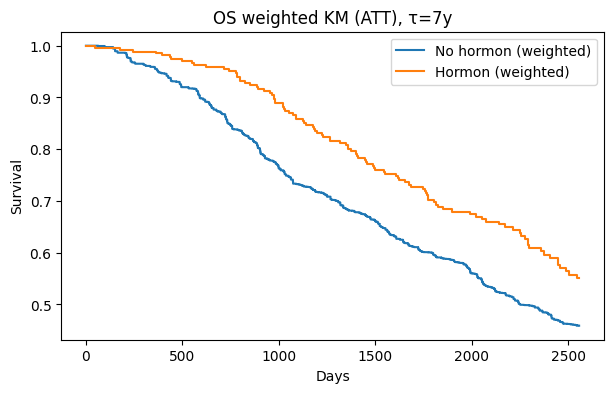

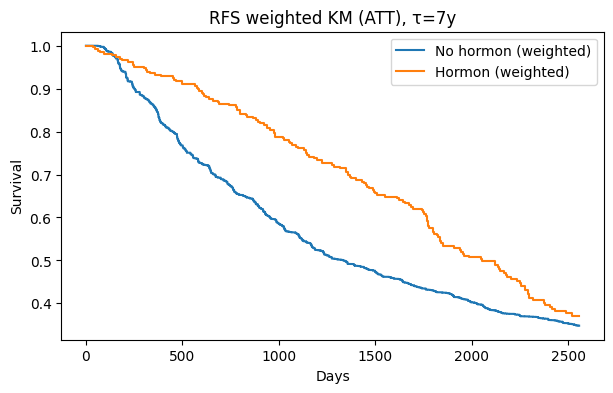

In [58]:
# Weighted KM (visual sanity)
def weighted_km(df_in, time_col, event_col, weight_col, title):
    km0 = KaplanMeierFitter()
    km1 = KaplanMeierFitter()

    d0 = df_in[df_in[TREAT_COL]==0]
    d1 = df_in[df_in[TREAT_COL]==1]

    km0.fit(d0[time_col], event_observed=d0[event_col], weights=d0[weight_col], label="No hormon (weighted)")
    km1.fit(d1[time_col], event_observed=d1[event_col], weights=d1[weight_col], label="Hormon (weighted)")

    plt.figure(figsize=(7,4))
    ax = km0.plot(ci_show=False)
    km1.plot(ax=ax, ci_show=False)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Survival")
    plt.show()

weighted_km(D_cs, "dtime_tau", "death_tau", "w_att_trunc", f"OS weighted KM (ATT), τ={TAU_YEARS}y")
weighted_km(D_cs, "rfstime_tau_royston", "rfs_tau_royston", "w_att_trunc", f"RFS weighted KM (ATT), τ={TAU_YEARS}y")


## 7) Method C - G-formula (outcome regression)

Fit an outcome model, then predict counterfactual outcomes for treated patients:
- survival under T=1 and under T=0 for each treated patient
- average across treated to obtain ATT at $\tau$


In [59]:
# Outcome model for OS: Cox with covariates + treatment
g_os = D_cs[[TREAT_COL,"dtime_tau","death_tau"] + cov_cont_smd + cov_bin_smd + cov_cat_smd].copy()
g_os = pd.get_dummies(g_os, columns=cov_cat_smd, drop_first=True)

g_os = g_os.rename(columns={"dtime_tau":"T", "death_tau":"E"})
cph_g = CoxPHFitter()
cph_g.fit(g_os, duration_col="T", event_col="E")
cph_g.summary.head(10)


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hormon,-0.348628,0.705655,0.113288,-0.570669,-0.126587,0.565147,0.881097,0.0,-3.077353,2.088482e-03,8.903330
age,0.013590,1.013683,0.005224,0.003352,0.023828,1.003358,1.024115,0.0,2.601648,9.277713e-03,6.752015
log_nodes,0.632554,1.882412,0.043983,0.546350,0.718758,1.726938,2.051883,0.0,14.381945,6.717982e-47,153.382593
er,-0.000083,0.999917,0.000142,-0.000361,0.000196,0.999639,1.000196,0.0,-0.582192,5.604371e-01,0.835376
pgr,-0.000209,0.999791,0.000161,-0.000524,0.000107,0.999476,1.000107,0.0,-1.296097,1.949422e-01,2.358881
meno,-0.141169,0.868342,0.139445,-0.414476,0.132138,0.660686,1.141266,0.0,-1.012365,3.113636e-01,1.683328
chemo,-0.225671,0.797981,0.114403,-0.449897,-0.001445,0.637694,0.998556,0.0,-1.972592,4.854202e-02,4.364622
er_pos,-0.125144,0.882369,0.179297,-0.476559,0.226270,0.620916,1.253915,0.0,-0.697974,4.851932e-01,1.043369
pgr_pos,-0.322962,0.724001,0.099794,-0.518556,-0.127369,0.595380,0.880409,0.0,-3.236275,1.211007e-03,9.689577


In [60]:
# G-formula ATT at tau: average survival among treated under T=1 vs T=0
treated_rows = g_os[g_os[TREAT_COL]==1].copy()

treated_T1 = treated_rows.copy()
treated_T0 = treated_rows.copy()
treated_T1[TREAT_COL] = 1
treated_T0[TREAT_COL] = 0

# Predict survival probability at TAU_DAYS
S1 = cph_g.predict_survival_function(treated_T1, times=[TAU_DAYS]).T.iloc[:,0]
S0 = cph_g.predict_survival_function(treated_T0, times=[TAU_DAYS]).T.iloc[:,0]

att_surv = float(S1.mean() - S0.mean())
att_risk = float((1-S1).mean() - (1-S0).mean())

print(f"G-formula ATT at τ={TAU_YEARS}y: ΔSurvival={att_surv:.4f}, ΔRisk(death)={att_risk:.4f}")


G-formula ATT at τ=7y: ΔSurvival=0.1041, ΔRisk(death)=-0.1041


In [61]:
# Repeat G-formula for RFS (Royston definition)
g_rfs = D_cs[[TREAT_COL,"rfstime_tau_royston","rfs_tau_royston"] + cov_cont_smd + cov_bin_smd + cov_cat_smd].copy()
g_rfs = pd.get_dummies(g_rfs, columns=cov_cat_smd, drop_first=True)

g_rfs = g_rfs.rename(columns={"rfstime_tau_royston":"T", "rfs_tau_royston":"E"})
cph_g_rfs = CoxPHFitter()
cph_g_rfs.fit(g_rfs, duration_col="T", event_col="E")

treated_rows = g_rfs[g_rfs[TREAT_COL]==1].copy()
treated_T1 = treated_rows.copy(); treated_T1[TREAT_COL]=1
treated_T0 = treated_rows.copy(); treated_T0[TREAT_COL]=0

S1 = cph_g_rfs.predict_survival_function(treated_T1, times=[TAU_DAYS]).T.iloc[:,0]
S0 = cph_g_rfs.predict_survival_function(treated_T0, times=[TAU_DAYS]).T.iloc[:,0]

att_surv_rfs = float(S1.mean() - S0.mean())
att_risk_rfs = float((1-S1).mean() - (1-S0).mean())

print(f"G-formula ATT at τ={TAU_YEARS}y: ΔSurvival(RFS)={att_surv_rfs:.4f}, ΔRisk(RFS-event)={att_risk_rfs:.4f}")


G-formula ATT at τ=7y: ΔSurvival(RFS)=0.1008, ΔRisk(RFS-event)=-0.1008


## 8) Comparison table

Summary of key effect estimates:
- matched Cox HR (OS + RFS)
- IPTW ATT Cox HR (OS + RFS)
- G-formula ATT risk difference at $\tau$ (OS + RFS)


In [62]:
def hr_from_cph(summary, var=TREAT_COL):
    row = summary.loc[var]
    return float(np.exp(row["coef"])), float(row["exp(coef) lower 95%"]), float(row["exp(coef) upper 95%"])

hr_os_match = hr_from_cph(cph.summary)
hr_rfs_match = hr_from_cph(cph_rfs.summary)

hr_os_iptw = hr_from_cph(cph_w.summary)
hr_rfs_iptw = hr_from_cph(cph_w_rfs.summary)

res = pd.DataFrame({
    "Method": ["PS matching (stratified Cox)", "IPTW (ATT, weighted Cox)", "G-formula (Cox OR)"],
    "OS measure": [f"HR={hr_os_match[0]:.3f} [{hr_os_match[1]:.3f},{hr_os_match[2]:.3f}]",
                   f"HR={hr_os_iptw[0]:.3f} [{hr_os_iptw[1]:.3f},{hr_os_iptw[2]:.3f}]",
                   f"ΔRisk@τ={att_risk:.3f}"],
    "RFS measure": [f"HR={hr_rfs_match[0]:.3f} [{hr_rfs_match[1]:.3f},{hr_rfs_match[2]:.3f}]",
                    f"HR={hr_rfs_iptw[0]:.3f} [{hr_rfs_iptw[1]:.3f},{hr_rfs_iptw[2]:.3f}]",
                    f"ΔRisk@τ={att_risk_rfs:.3f}"],
})
res


,Method,OS measure,RFS measure
0,PS matching (stratified Cox),"HR=3208574.862 [0.000,inf]","HR=2425316.874 [0.000,inf]"
1,"IPTW (ATT, weighted Cox)","HR=0.716 [0.568,0.902]","HR=0.713 [0.582,0.873]"
2,G-formula (Cox OR),ΔRisk@τ=-0.104,ΔRisk@τ=-0.101


## 9) Sensitivity checks (minimum set)

1) **RFS definition:** Royston-style vs conservative censoring.  
2) **Weight truncation:** already applied via 1%-99% clip.  
3) **PS model:** alternative covariate transform (e.g., `inv_sqrt_nodes` instead of `log_nodes`).


In [69]:
# 9.1 RFS definition sensitivity: rerun IPTW Cox with conservative RFS
w_rfs_cons = D_cs[[TREAT_COL,"rfstime_tau_cons","rfs_tau_cons","w_att_trunc"] + cov_cont_smd + cov_bin_smd].copy()
w_rfs_cons = w_rfs_cons.rename(columns={"rfstime_tau_cons":"T", "rfs_tau_cons":"E", "w_att_trunc":"W"})

cph_w_rfs_cons = CoxPHFitter()
cph_w_rfs_cons.fit(w_rfs_cons, duration_col="T", event_col="E", weights_col="W", robust=True)
cph_w_rfs_cons.summary.loc[[TREAT_COL]]


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hormon,-0.392863,0.675121,0.117139,-0.622452,-0.163275,0.536627,0.849358,0.0,-3.353815,0.000797,10.293033


In [70]:
# 9.2 PS model sensitivity: switch nodes transform to 1/sqrt(nodes)
D2 = df_eligible.copy()

cov_cont_alt = ["age","inv_sqrt_nodes","er","pgr"]
X2 = D2[cov_cont_alt + cov_bin + cov_cat]
y2 = D2[TREAT_COL].astype(int)

preprocess2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cov_cat),
        ("num", "passthrough", cov_cont_alt + cov_bin)
    ],
    remainder="drop"
)

ps_model2 = Pipeline(steps=[
    ("prep", preprocess2),
    ("logit", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

ps_model2.fit(X2, y2)
ps2 = ps_model2.predict_proba(X2)[:,1]
D2["ps"] = ps2
D2["logit_ps"] = np.log(ps2/(1-ps2))

# Common support bounds from treated
ps_treated = D2.loc[D2[TREAT_COL]==1, "ps"]
lo2, hi2 = ps_treated.quantile(0.01), ps_treated.quantile(0.99)
D2_cs = D2[(D2["ps"]>=lo2) & (D2["ps"]<=hi2)].copy()

W2 = np.where(D2_cs[TREAT_COL]==1, 1.0, D2_cs["ps"]/(1.0 - D2_cs["ps"]))
D2_cs["w_att"] = W2
w_lo2, w_hi2 = np.quantile(D2_cs["w_att"], [0.01, 0.99])
D2_cs["w_att_trunc"] = D2_cs["w_att"].clip(w_lo2, w_hi2)

w_os2 = D2_cs[[TREAT_COL,"dtime_tau","death_tau","w_att_trunc"] + ["age","inv_sqrt_nodes","er","pgr"] + cov_bin].copy()
w_os2 = w_os2.rename(columns={"dtime_tau":"T","death_tau":"E","w_att_trunc":"W"})
cph_w2 = CoxPHFitter()
cph_w2.fit(w_os2, duration_col="T", event_col="E", weights_col="W", robust=True)

print("Sensitivity HR (OS, IPTW ATT) with inv_sqrt_nodes PS:", 
      float(np.exp(cph_w2.summary.loc[TREAT_COL,"coef"])))


Sensitivity HR (OS, IPTW ATT) with inv_sqrt_nodes PS: 0.674980098765901


### Optional: unmeasured confounding sensitivity (E-value)

E-value gives the minimum strength of association an unmeasured confounder would need with both treatment and outcome (risk ratio scale) to explain away the observed effect. It is a quick sanity check, not a guarantee.


In [71]:
def e_value_rr(rr):
    # VanderWeele & Ding (2017). Works for RR or approximate HR.
    if rr < 1:
        rr = 1/rr
    return rr + np.sqrt(rr*(rr-1))

# Use HRs as RR approximations (common in quick sensitivity writeups)
hr_os_m = hr_os_match[0]
hr_os_w = hr_os_iptw[0]

print("E-value (OS HR, matching):", round(e_value_rr(hr_os_m), 3))
print("E-value (OS HR, IPTW):    ", round(e_value_rr(hr_os_w), 3))


E-value (OS HR, matching): 6417149.225
E-value (OS HR, IPTW):     2.14


## 10) Which method to present as primary?

Given the target is **ATT** and hormonal therapy assignment is strongly driven by receptor biology, the default choice is:
- **Primary:** PS matching (ATT). Clear overlap, interpretable matched cohorts, avoids extreme weights.
- **Secondary:** IPTW ATT and g-formula as robustness checks; disagreement points to overlap or model issues.

For the report: show the overlap plot, a love plot, and a compact comparison table.


## References to motivate modeling choices (for the report)

- The project spec frames hormonal therapy as the exposure and recurrence/mortality as outcomes; a causal analysis is expected.  
- Late recurrence is common in ER+ disease and endocrine therapy is extended in practice; confounding by indication is likely.  
- Prognostic gene signatures exist (e.g., MammaPrint), but are not always available, so adjustment relies on clinicopathologic covariates.

(Cite the uploaded PDFs from the submission folder.)
